IMPORTANT:
SOME OF THE SETTINGS ARE INTERACTIVE AND CAN BE CHANGED BY THE USER! THEY ARE MARKED WITH "#CHANGE: " YOU CAN INVESTIGATE YOUR OWN DATA ETC. IN THIS WAY. 

In [1]:
import pandas as pd
import re
import numpy as np
from sklearn.metrics import cohen_kappa_score
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters
import itertools
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd
import numpy as np
from typing import List, Optional, Union

from utils import helper
import importlib
importlib.reload(helper)
from utils.site_config_colors import SITE_CONFIG_KI_Vergleich
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
PSY_REGEX = r'^p\d+_.*_final$'
PSY_REGEX_REDUCED = r'^p\d+_.*_final_reduced$'
output_folder_tables = "../outputs/tables"
output_folder_figures = "../outputs/figures"
source_folder= "../data/00_ratings"


Loading the Data from the study

add own csv path if needed

In [2]:
ki_master = pd.read_csv(f"{source_folder}/ki_master.csv")
#CHANGE: If you want to add new ratings do it here and add full path. 
#IMPORTANT: The COLUMNS MUST FIT WITH THE REFERENCE AND THE ANALYSES FOLLOWING! BEST IS TO GENERATE THE RATINGS WITH THE PROMPT FROM THE REPO AND THE SCRIPT "00_call_models.py"

#example for custom path:
#ki_master = pd.read_csv("../outputs/AI_ratings/all_runs_combined_definitions_10_20251230_161916_0.0.csv") # Example for a custom path

ki_master["site"].unique()

array(['gemini-3-pro-preview_0', 'gpt-4o-mini_0',
       'mistral-large-latest_0', 'claude-sonnet-4-5_0', 'gpt-5.1_0',
       'gemini-2.5-flash_0', 'Qwen_Qwen3-Next-80B-A3B-Thinking_0',
       'deepseek-ai_DeepSeek-R1_0', 'openai_gpt-oss-20b_0',
       'moonshotai_Kimi-K2-Thinking_0', 'gemini-3-pro-preview_10',
       'gpt-4o-mini_10', 'mistral-large-latest_10',
       'claude-sonnet-4-5_10', 'gpt-5.1_10', 'gemini-2.5-flash_10',
       'Qwen_Qwen3-Next-80B-A3B-Thinking_10',
       'deepseek-ai_DeepSeek-R1_10', 'openai_gpt-oss-20b_10',
       'moonshotai_Kimi-K2-Thinking_10',
       'Qwen_Qwen3-Next-80B-A3B-Thinking_temp_0_0',
       'Qwen_Qwen3-Next-80B-A3B-Thinking_temp_0_10',
       'claude-sonnet-4-5_temp_0_0', 'claude-sonnet-4-5_temp_0_10',
       'deepseek-ai_DeepSeek-R1_temp_0_0',
       'deepseek-ai_DeepSeek-R1_temp_0_10', 'gemini-2.5-flash_temp_0_0',
       'gemini-2.5-flash_temp_0_10', 'gemini-3-pro-preview_temp_0_0',
       'gemini-3-pro-preview_temp_0_10', 'gpt-4o-mini_temp_

In [3]:
best_ai = "gpt-5.1_10" 
#CHANGE to a site that is available in ki_master.csv, if you want to change the final best AI Reference model
#IMPROTANT: THAT SITE MUST BE PRESENT IN THE KI_MASTER.CSV look at the output above
#best_ai= "gemini_10" # Example for change

In [4]:
#LOAD THE KI - RATING -> THIS PART HAS TO BE ADJUSTED IF YOU WANT TO USE IT WITH NEW RATINGS
ki_master = helper.map_psy_columns_to_english(
    df=ki_master,
    inplace=False
)
ki_master.rename(columns={"id": "ids"}, inplace=True)
#delte _final from columns that have begrüdung in their name
cols_with_begruendung = [col for col in ki_master.columns if "begründung" in col]
for col in cols_with_begruendung:
    new_col_name = col.replace("_final", "")
    ki_master.rename(columns={col: new_col_name}, inplace=True)

In [5]:
human_master = pd.read_csv(f"{source_folder}/human_master.csv")
reference = pd.read_csv(f"{source_folder}/reference.csv")
reference_reduced = helper.reduce_data_to_3_categories(
    psy_cols=helper.extract_psy_cols(reference, PSY_REGEX),
    dfs=[reference]
)[0].drop(columns=helper.extract_psy_cols(reference, PSY_REGEX))
dictionary = pd.read_csv(f"{source_folder}/FinalOnlineQuestionnaire_DataDictionary_2025-11-12.csv")
best_ki = ki_master[ki_master["site"] == best_ai]
best_ki = helper.reduce_data_to_3_categories(
    psy_cols=helper.extract_psy_cols(best_ki, PSY_REGEX),
    dfs=[best_ki]
)[0]
master_df = pd.concat([human_master, best_ki], ignore_index=True)

Overview of the structure of the outputs

In [6]:
ki_master[ki_master["site"] == best_ai].head()

#video_ids that are in the Ki_master
video_ids_in_ki_master = ki_master["video_id"].unique().tolist()

Generating the rating the overview-Table for Humans regarding the Reference

In [7]:
psy_cols = helper.extract_psy_cols(human_master, psy_cols_regex=r'^p\d+_.*_final$')
psy_cols_reduced = helper.extract_psy_cols(human_master, psy_cols_regex=PSY_REGEX_REDUCED)
df_human_vs_ref = helper.human_vs_reference_df(
    human_master=human_master,
    reference=reference,
    psy_cols=psy_cols,
    video_ids=[7, 8, 9],  
    rating_levels=[0, 1, 2, 3, -99]
)
print(df_human_vs_ref.head())
df_human_vs_ref['item_num'] = df_human_vs_ref['item'].str.extract(r'^p(\d+)_', expand=False).astype(int)
df_human_vs_ref = df_human_vs_ref.sort_values(['video_id', 'item_num']).reset_index(drop=True)
df_human_vs_ref = df_human_vs_ref.drop(columns=['item_num'])
df_human_vs_ref.to_excel(f"{output_folder_tables}/human_vs_reference_detailed.xlsx", index=False)

   video_id                                   item  reference  human_total  \
0         7               p100_need_for_care_final          0           53   
1         7      p10_disturbed_concentration_final          2           53   
2         7  p11_disturbed_short-term_memory_final          1           53   
3         7   p12_disturbed_long-term_memory_final        -99           53   
4         7                p13_confabulation_final          0           53   

   human_mean  human_correct_n  human_correct_pct  count_0  count_1  count_2  \
0  -22.226415               36          67.924528       36        2        1   
1    1.792453               27          50.943396        1       17       27   
2    1.018868               38          71.698113        8       38        5   
3  -10.603774                6          11.320755       24       16        5   
4   -9.056604               40          75.471698       40        4        1   

   count_3  count_-99  
0        2         12  
1 

Aggregation of the perfomances

In [8]:
groups_dict_not_reduced_all = {
    "all_items": [0,1,2,3,-99],
}
groups_dict_reduced_all = {
    "all_items": [0,1,-99],
}
_, _, aggregated_results_all_videos_vs_ai = helper.plot_all_videos_vs_ai(
    human_master=ki_master,
    reference_all=reference,
    site_config=SITE_CONFIG_KI_Vergleich,
    psy_cols_regex=PSY_REGEX,
    vid_ids_to_use=video_ids_in_ki_master,
    ref_VID_col="ID_Video",
    rat_VID_col="video_id",
    title_suffix="All videos - KI Vergleich",
    show_annotations=True,
    show_error_bars=False,
    groups_dict_not_reduced=groups_dict_not_reduced_all,
    groups_dict_reduced=groups_dict_reduced_all,
    annotate_best_only=False,
    fontsize_annotations=15,
    show_std_values=False,
    skip_plotting=True #CHANGE to False if you want to see extensive Barplots -> could be not working with custom data
    
)
agg_nr, agg_rd, agg_nr_mode, agg_rd_mode = aggregated_results_all_videos_vs_ai

Computeing site 'Qwen_Qwen3-Next-80B-A3B-Thinking_0'
Computeing site 'Qwen_Qwen3-Next-80B-A3B-Thinking_10'
Computeing site 'Qwen_Qwen3-Next-80B-A3B-Thinking_temp_0_0'
Computeing site 'Qwen_Qwen3-Next-80B-A3B-Thinking_temp_0_10'
Computeing site 'claude-sonnet-4-5_0'
Computeing site 'claude-sonnet-4-5_10'
Computeing site 'claude-sonnet-4-5_temp_0_0'
Computeing site 'claude-sonnet-4-5_temp_0_10'
Computeing site 'deepseek-ai_DeepSeek-R1_0'
Computeing site 'deepseek-ai_DeepSeek-R1_10'
Computeing site 'deepseek-ai_DeepSeek-R1_temp_0_0'
Computeing site 'deepseek-ai_DeepSeek-R1_temp_0_10'
Computeing site 'gemini-2.5-flash_0'
Computeing site 'gemini-2.5-flash_10'
Computeing site 'gemini-2.5-flash_temp_0_0'
Computeing site 'gemini-2.5-flash_temp_0_10'
Computeing site 'gemini-3-pro-preview_0'
Computeing site 'gemini-3-pro-preview_10'
Computeing site 'gemini-3-pro-preview_temp_0_0'
Computeing site 'gemini-3-pro-preview_temp_0_10'
Computeing site 'gpt-4o-mini_0'
Computeing site 'gpt-4o-mini_10'
Com

Experimental Design
<div style="background-color: white; padding: 10px; border-radius: 5px;">

![Simulation Setup](../data/03_ressources/Experimental_design.png)

</div>

Simulated patient interviews assessed via three pathways: practicing clinicians (n=108), expert consensus panel (n=3 AMDP trainers), and LLMs (n=10 models). LLMs evaluated transcripts under four conditions: temperature 0.0 or 0.5 (with majority voting for T>0) × with/without AMDP definitions. All ratings compared against expert ground truth.

Performance of the different Models in a Table

In [9]:
from IPython.display import display, HTML
try:
    df_not_reduced = helper.build_performance_table(agg_nr, range_option="range")
    df_reduced = helper.build_performance_table(agg_rd, range_option="range")

    display(HTML("<h3>Not Reduced — All Videos</h3>"))
    display(df_not_reduced)
    display(HTML("<h3>Reduced — All Videos</h3>"))
    display(df_reduced)
except NameError as e:
    print("Required variables (agg_nr, agg_rd) are not defined in this kernel.")
    raise

df_merged_range = helper.build_merged_performance_table(
    df_not_reduced, 
    df_reduced, 
    sort_by='reduced_max'
)

display(HTML("<h3>Combined Performance Table — Not Reduced / Reduced (Range)</h3>"))
display(HTML("<p><i>Format: Not Reduced (min - max) / Reduced (min - max)</i></p>"))
display(df_merged_range)

# Save to Excel
df_merged_range.to_excel(f"{output_folder_tables}/table_llms_merged_range.xlsx", index=False)

,Model,Temp 0 No Knowledge (min - max),Temp 0 With Knowledge (min - max),Temp 0.5 No Knowledge (min - max),Temp 0.5 With Knowledge (min - max)
0,Qwen_Qwen3-Next-80B-A3B-Thinking,0.59 (0.42 - 0.72),0.44 (0.38 - 0.47),0.58 (0.37 - 0.74),0.44 (0.37 - 0.50)
1,claude-sonnet-4-5,0.57 (0.39 - 0.75),0.52 (0.39 - 0.65),0.56 (0.32 - 0.75),0.53 (0.40 - 0.64)
2,deepseek-ai_DeepSeek-R1,0.62 (0.43 - 0.79),0.37 (0.31 - 0.45),0.45 (0.23 - 0.75),0.37 (0.26 - 0.50)
3,gemini-2.5-flash,0.56 (0.39 - 0.72),0.53 (0.47 - 0.65),0.58 (0.35 - 0.77),0.53 (0.40 - 0.67)
4,gemini-3-pro-preview,0.61 (0.46 - 0.77),0.63 (0.45 - 0.83),0.61 (0.41 - 0.78),0.63 (0.44 - 0.83)
5,gpt-4o-mini,0.57 (0.35 - 0.70),0.38 (0.21 - 0.47),0.53 (0.28 - 0.73),0.42 (0.23 - 0.56)
6,gpt-5.1,0.62 (0.43 - 0.79),0.67 (0.59 - 0.76),0.60 (0.47 - 0.83),0.64 (0.49 - 0.76)
7,mistral-large-latest,0.57 (0.38 - 0.73),0.51 (0.31 - 0.71),0.54 (0.25 - 0.75),0.49 (0.29 - 0.67)
8,moonshotai_Kimi-K2-Thinking,0.51 (0.38 - 0.70),0.52 (0.45 - 0.64),0.52 (0.16 - 0.78),0.56 (0.46 - 0.70)
9,openai_gpt-oss-20b,0.30 (0.21 - 0.38),0.29 (0.20 - 0.38),0.30 (0.14 - 0.56),0.42 (0.33 - 0.53)


,Model,Temp 0 No Knowledge (min - max),Temp 0 With Knowledge (min - max),Temp 0.5 No Knowledge (min - max),Temp 0.5 With Knowledge (min - max)
0,Qwen_Qwen3-Next-80B-A3B-Thinking,0.67 (0.49 - 0.83),0.54 (0.46 - 0.58),0.66 (0.44 - 0.84),0.54 (0.45 - 0.61)
1,claude-sonnet-4-5,0.68 (0.53 - 0.85),0.62 (0.50 - 0.75),0.66 (0.43 - 0.85),0.63 (0.51 - 0.73)
2,deepseek-ai_DeepSeek-R1,0.69 (0.51 - 0.87),0.46 (0.41 - 0.55),0.54 (0.32 - 0.84),0.46 (0.37 - 0.60)
3,gemini-2.5-flash,0.67 (0.49 - 0.84),0.63 (0.55 - 0.74),0.66 (0.45 - 0.88),0.64 (0.50 - 0.75)
4,gemini-3-pro-preview,0.70 (0.55 - 0.85),0.72 (0.56 - 0.87),0.70 (0.50 - 0.87),0.72 (0.55 - 0.87)
5,gpt-4o-mini,0.65 (0.42 - 0.82),0.47 (0.30 - 0.60),0.61 (0.34 - 0.83),0.50 (0.30 - 0.66)
6,gpt-5.1,0.71 (0.53 - 0.86),0.73 (0.65 - 0.82),0.69 (0.56 - 0.87),0.71 (0.55 - 0.83)
7,mistral-large-latest,0.67 (0.48 - 0.82),0.61 (0.43 - 0.77),0.64 (0.37 - 0.83),0.60 (0.41 - 0.75)
8,moonshotai_Kimi-K2-Thinking,0.59 (0.47 - 0.75),0.62 (0.55 - 0.74),0.60 (0.25 - 0.87),0.67 (0.56 - 0.80)
9,openai_gpt-oss-20b,0.36 (0.28 - 0.46),0.35 (0.27 - 0.43),0.39 (0.23 - 0.65),0.50 (0.41 - 0.60)


Detected range_option: range
Looking for pattern: '(min - max)'

Found 4 condition columns in not-reduced
Found 4 condition columns in reduced
Merged dataframe shape: (10, 9)
Merged columns: ['Model', 'Temp 0 No Knowledge (min - max)_NR', 'Temp 0 With Knowledge (min - max)_NR', 'Temp 0.5 No Knowledge (min - max)_NR', 'Temp 0.5 With Knowledge (min - max)_NR', 'Temp 0 No Knowledge (min - max)_R', 'Temp 0 With Knowledge (min - max)_R', 'Temp 0.5 No Knowledge (min - max)_R', 'Temp 0.5 With Knowledge (min - max)_R']

Looking for NR column: 'Temp 0 No Knowledge (min - max)_NR'
Looking for R column: 'Temp 0 No Knowledge (min - max)_R'
Available columns: ['Temp 0 No Knowledge (min - max)_NR', 'Temp 0 No Knowledge (min - max)_R']

Looking for NR column: 'Temp 0 With Knowledge (min - max)_NR'
Looking for R column: 'Temp 0 With Knowledge (min - max)_R'
Available columns: ['Temp 0 With Knowledge (min - max)_NR', 'Temp 0 With Knowledge (min - max)_R']

Looking for NR column: 'Temp 0.5 No Knowledge 

,Model,Temp 0 No Knowledge (min - max) (NR / R),Temp 0 With Knowledge (min - max) (NR / R),Temp 0.5 No Knowledge (min - max) (NR / R),Temp 0.5 With Knowledge (min - max) (NR / R)
0,gpt-5.1,0.62 (0.43 - 0.79) / 0.71 (0.53 - 0.86),0.67 (0.59 - 0.76) / 0.73 (0.65 - 0.82),0.60 (0.47 - 0.83) / 0.69 (0.56 - 0.87),0.64 (0.49 - 0.76) / 0.71 (0.55 - 0.83)
1,gemini-3-pro-preview,0.61 (0.46 - 0.77) / 0.70 (0.55 - 0.85),0.63 (0.45 - 0.83) / 0.72 (0.56 - 0.87),0.61 (0.41 - 0.78) / 0.70 (0.50 - 0.87),0.63 (0.44 - 0.83) / 0.72 (0.55 - 0.87)
2,deepseek-ai_DeepSeek-R1,0.62 (0.43 - 0.79) / 0.69 (0.51 - 0.87),0.37 (0.31 - 0.45) / 0.46 (0.41 - 0.55),0.45 (0.23 - 0.75) / 0.54 (0.32 - 0.84),0.37 (0.26 - 0.50) / 0.46 (0.37 - 0.60)
3,claude-sonnet-4-5,0.57 (0.39 - 0.75) / 0.68 (0.53 - 0.85),0.52 (0.39 - 0.65) / 0.62 (0.50 - 0.75),0.56 (0.32 - 0.75) / 0.66 (0.43 - 0.85),0.53 (0.40 - 0.64) / 0.63 (0.51 - 0.73)
4,Qwen_Qwen3-Next-80B-A3B-Thinking,0.59 (0.42 - 0.72) / 0.67 (0.49 - 0.83),0.44 (0.38 - 0.47) / 0.54 (0.46 - 0.58),0.58 (0.37 - 0.74) / 0.66 (0.44 - 0.84),0.44 (0.37 - 0.50) / 0.54 (0.45 - 0.61)
5,gemini-2.5-flash,0.56 (0.39 - 0.72) / 0.67 (0.49 - 0.84),0.53 (0.47 - 0.65) / 0.63 (0.55 - 0.74),0.58 (0.35 - 0.77) / 0.66 (0.45 - 0.88),0.53 (0.40 - 0.67) / 0.64 (0.50 - 0.75)
6,mistral-large-latest,0.57 (0.38 - 0.73) / 0.67 (0.48 - 0.82),0.51 (0.31 - 0.71) / 0.61 (0.43 - 0.77),0.54 (0.25 - 0.75) / 0.64 (0.37 - 0.83),0.49 (0.29 - 0.67) / 0.60 (0.41 - 0.75)
7,moonshotai_Kimi-K2-Thinking,0.51 (0.38 - 0.70) / 0.59 (0.47 - 0.75),0.52 (0.45 - 0.64) / 0.62 (0.55 - 0.74),0.52 (0.16 - 0.78) / 0.60 (0.25 - 0.87),0.56 (0.46 - 0.70) / 0.67 (0.56 - 0.80)
8,gpt-4o-mini,0.57 (0.35 - 0.70) / 0.65 (0.42 - 0.82),0.38 (0.21 - 0.47) / 0.47 (0.30 - 0.60),0.53 (0.28 - 0.73) / 0.61 (0.34 - 0.83),0.42 (0.23 - 0.56) / 0.50 (0.30 - 0.66)
9,openai_gpt-oss-20b,0.30 (0.21 - 0.38) / 0.36 (0.28 - 0.46),0.29 (0.20 - 0.38) / 0.35 (0.27 - 0.43),0.30 (0.14 - 0.56) / 0.39 (0.23 - 0.65),0.42 (0.33 - 0.53) / 0.50 (0.41 - 0.60)


Per Video performances of the models

In [10]:
per_video_results = helper.compute_per_video_results_reduced(human_master=ki_master, reference_all=reference, psy_cols_regex=PSY_REGEX)
df_best_reduced = helper.build_best_per_video_table_with_settings(per_video_results, use_reduced=True, combine_nr_r=True, use_range=True)
df_best_reduced_compact = helper.build_best_per_video_table_compact(per_video_results, use_reduced=True, combine_nr_r=True, use_range=True)
df_best_reduced_summary = helper.build_best_per_video_with_summary_stats(per_video_results, use_reduced=True, combine_nr_r=True, use_range=True)

df_best_reduced.to_excel(f"{output_folder_tables}/table_llms_best_per_video_reduced.xlsx", index=False)
df_best_reduced_sorted = df_best_reduced.sort_values(by="Schizophrenia", ascending=False)
df_best_reduced_sorted.to_excel(f"{output_folder_tables}/reduced_llm_per_video.xlsx", index=False)
df_best_reduced_sorted.head()

Computeing site 'Qwen_Qwen3-Next-80B-A3B-Thinking_0'
Computeing site 'Qwen_Qwen3-Next-80B-A3B-Thinking_10'
Computeing site 'Qwen_Qwen3-Next-80B-A3B-Thinking_temp_0_0'
Computeing site 'Qwen_Qwen3-Next-80B-A3B-Thinking_temp_0_10'
Computeing site 'claude-sonnet-4-5_0'
Computeing site 'claude-sonnet-4-5_10'
Computeing site 'claude-sonnet-4-5_temp_0_0'
Computeing site 'claude-sonnet-4-5_temp_0_10'
Computeing site 'deepseek-ai_DeepSeek-R1_0'
Computeing site 'deepseek-ai_DeepSeek-R1_10'
Computeing site 'deepseek-ai_DeepSeek-R1_temp_0_0'
Computeing site 'deepseek-ai_DeepSeek-R1_temp_0_10'
Computeing site 'gemini-2.5-flash_0'
Computeing site 'gemini-2.5-flash_10'
Computeing site 'gemini-2.5-flash_temp_0_0'
Computeing site 'gemini-2.5-flash_temp_0_10'
Computeing site 'gemini-3-pro-preview_0'
Computeing site 'gemini-3-pro-preview_10'
Computeing site 'gemini-3-pro-preview_temp_0_0'
Computeing site 'gemini-3-pro-preview_temp_0_10'
Computeing site 'gpt-4o-mini_0'
Computeing site 'gpt-4o-mini_10'
Com

,Model,Mania,Depression,Schizophrenia
25,gpt-5.1 [T0-With-K],0.650 / 0.730,0.760 / 0.820,0.590 / 0.650
27,gpt-5.1 [T0.5-With-K],0.663 (0.650 - 0.670) / 0.760 (0.750 - 0.770),0.723 (0.700 - 0.760) / 0.783 (0.750 - 0.830),0.533 (0.490 - 0.590) / 0.597 (0.550 - 0.660)
14,gemini-2.5-flash [T0.5-No-K],0.637 (0.590 - 0.670) / 0.707 (0.690 - 0.720),0.613 (0.350 - 0.770) / 0.720 (0.450 - 0.880),0.480 (0.450 - 0.500) / 0.547 (0.510 - 0.570)
26,gpt-5.1 [T0.5-No-K],0.630 (0.600 - 0.650) / 0.733 (0.700 - 0.770),0.700 (0.520 - 0.830) / 0.763 (0.590 - 0.870),0.477 (0.470 - 0.480) / 0.573 (0.560 - 0.590)
35,moonshotai_Kimi-K2-Thinking [T0.5-With-K],0.583 (0.520 - 0.640) / 0.680 (0.610 - 0.730),0.630 (0.570 - 0.700) / 0.737 (0.670 - 0.800),0.477 (0.460 - 0.490) / 0.583 (0.560 - 0.610)


Interactive View of ALL Raters! (CAVE: DIFFERENT FROM NEXT PLOT JUST FOR THE BEST RATERS)

In [11]:
reduced_cols = [col for col in master_df.columns if "reduced" in col]
figures = helper.create_interactive_error_scatter_with_begruendung(
    master_df=master_df.drop(columns=reduced_cols),
    reference=reference,
    best_ai=best_ai,
    psy_cols=psy_cols,
    video_ids=video_ids_in_ki_master
)


Video 7 - Mania
Total items: 100
LLM correct: 76
LLM wrong: 24
Tie: 0



Video 8 - Depression
Total items: 100
LLM correct: 80
LLM wrong: 20
Tie: 0



Video 9 - Schizophrenia
Total items: 100
LLM correct: 60
LLM wrong: 40
Tie: 0


Filtering for Top 30 Percentile

In [12]:
rater_df_reduced, summary, winrate_result, per_video_df_reduced = helper.ai_majority_vs_human_rater_winrate_from_master(
    master_df=master_df.replace(np.nan,-99.0),
    reference_df=reference,
    ai_site_key=best_ai,
    human_site_keys=["clinic_3", "clinic_1", "clinic_2"],
    vid_col="video_id",
    ref_vid_col="ID_Video",
    site_col="site",
    id_col="id_code_v2",
    psy_cols_regex=PSY_REGEX_REDUCED,
    exclude_value=10000,
    videos_to_use=video_ids_in_ki_master,  
    ai_rater_id="AI_majority",
)


In [13]:
percentile_cutoff = 70
hum_acc = rater_df_reduced[rater_df_reduced["group"] == "human"].copy()
hum_acc = hum_acc.dropna(subset=["accuracy"]).copy()

# Merge accuracy onto master_df_copy
master_df_copy = master_df.copy()
master_df_copy = master_df_copy.merge(
    hum_acc[["rater_id", "accuracy"]].rename(columns={"rater_id": "id_code_v2",
                                                      "accuracy": "accuracy_human"}),
    on="id_code_v2",
    how="left"
)

# Flag high performers per video_id (top 30% = >=70th percentile)
def _flag_high_performers(group):
    cutoff = np.percentile(group["accuracy_human"].dropna(), percentile_cutoff)
    group["high_performer"] = (group["accuracy_human"] >= cutoff).astype(int)
    return group

master_df_copy = master_df_copy.groupby("video_id", group_keys=False).apply(_flag_high_performers)

high_performer_data = master_df_copy[master_df_copy["high_performer"] == 1].copy()
high_performer_data = pd.concat([
    high_performer_data,
    master_df[master_df["site"] == best_ai]])

Qualitative Comparision for top 30 Percentile

In [14]:
figures = helper.create_interactive_error_scatter_with_begruendung(
    master_df=high_performer_data.drop(columns=reduced_cols),
    reference=reference,
    best_ai=best_ai,
    psy_cols=psy_cols,
    video_ids=video_ids_in_ki_master,
    base_title="Error-Rate Comparision - TOP 30% Percentile"
)


Video 7 - Mania
Total items: 100
LLM correct: 76
LLM wrong: 24
Tie: 0



Video 8 - Depression
Total items: 100
LLM correct: 80
LLM wrong: 20
Tie: 0



Video 9 - Schizophrenia
Total items: 100
LLM correct: 60
LLM wrong: 40
Tie: 0


Get the Majority vote for the best model

In [15]:
ai_majority_df = helper.get_ai_majority_vote_with_justifications(
    master_df=master_df,
    ai_site_key=best_ai,
    psy_cols_regex=PSY_REGEX,
    vid_col="video_id",
    site_col="site",
    id_col="ids"
)

ai_majority_df_reduced = helper.reduce_data_to_3_categories(psy_cols=psy_cols, dfs=[ai_majority_df])[0]
master_df = pd.concat([
    master_df,
    ai_majority_df_reduced
], ignore_index=True)

print(f"Added {len(ai_majority_df_reduced)} majority vote rows for {best_ai}")
print(f"\nMajority vote site name: {ai_majority_df_reduced['site'].iloc[0]}")
print(f"Videos covered: {sorted(ai_majority_df_reduced['video_id'].unique())}")

# Verify justifications were added
begr_cols_check = [c for c in ai_majority_df.columns if 'begründung' in c]
print(f"\nJustification columns included: {len(begr_cols_check)}")

Added 3 majority vote rows for gpt-5.1_10

Majority vote site name: gpt-5.1_10_majority
Videos covered: [np.int64(7), np.int64(8), np.int64(9)]

Justification columns included: 100


Clinician-AI Collaboration Simulation Framework
<div style="background-color: white; padding: 10px; border-radius: 5px;">

![Simulation Setup](../data/03_ressources/Simulation_setup.png)


</div>

Simulation design for evaluating AI-supervised psychiatric assessment. From a pool of 108 clinician ratings, pairs were randomly sampled to simulate clinical teams (for all videos 2,091 pairs). Path A (Agreement): When both clinicians agreed on a symptom rating, their consensus was adopted. Path B (Disagreement): When clinicians disagreed, three supervision strategies were compared: (1) AI Supervision: The best-performing LLM (temperature=0.5, with AMDP definitions, majority voting across 3 inferences) provided the deciding rating. (2) Board-Certified (BC) Supervision: A randomly selected rating from the pool of board-certified psychiatrists who independently assessed the same video resolved the disagreement (traditional quality assurance model).  (3) No Supervision: Random selection between the two disagreeing clinicians (baseline control). All strategies were evaluated against the expert consensus ground truth. The combined ratings from agreement cases (Path A) and disagreement resolutions (Path B) were aggregated to calculate overall accuracy for each supervision approach.

In [16]:
master_df["psy_tätigkeit_jahre_v2_filled"] = master_df["psy_tätigkeit_jahre_v2"].fillna(
    master_df["psy_tätigkeit_jahre_v2"].mode()[0]
)

# Exclude AI models from human analysis
master_df = master_df[~master_df['site'].isin([best_ai])].copy()

simulation_results = helper.simulate_all_human_pairs_with_ai(
    master_df=master_df,
    reference_df=reference,
    ai_site_key=f"{best_ai}_majority",
    human_site_keys=["clinic_3", "clinic_1", "clinic_2"],
    psy_cols=psy_cols_reduced,
    vid_col="video_id",
    ref_vid_col="ID_Video",
    site_col="site",
    id_col="id_code_v2",
    exclude_value=10000,
    videos_to_use=video_ids_in_ki_master,
    haupttätigkeit_col="haupttätigkeit_v2",
    psychiatrist_codes=[2, 3, 5]  # Trained psychiatrists
)

helper.print_comparison_results(simulation_results['comparisons'])

# Print additional statistics
print("\n" + "="*80)
print("CONSULTATION STATISTICS")
print("="*80)
details = simulation_results['simulation_details']
print(f"Total pairs analyzed: {len(details)}")
print(f"Average disagreement rate: {details['disagreement_rate'].mean():.2%}")
print(f"Average AI consultations per pair: {details['ai_used'].mean():.1f}")
print(f"Average psychiatrist consultations per pair: {details['psychiatrist_consulted'].mean():.1f}")
print(f"Total psychiatrist consultations: {details['psychiatrist_consulted'].sum():.0f}")



PAIRWISE COMPARISON RESULTS WITH EFFECT SIZES

AI ALWAYS VS HUMAN ONLY
------------------------------------------------------------
Sample size: 2091 paired observations

Mean ai_always: 0.7373
Mean human_only: 0.6639
Mean difference: 0.0735

ai_always better: 1882/2091
human_only better: 124/2091
Ties: 85/2091

Statistical Tests:
  Paired t-test:  t = 57.850, p = 0 ***
  Wilcoxon test:  W = 31276.0, p = 2.423e-309 ***

Effect Sizes:
  Cohen's d:        +1.265 (large)
    Interpretation: Small=0.2, Medium=0.5, Large=0.8
  r effect size:    +0.785 (large)
    Interpretation: Small=0.1, Medium=0.3, Large=0.5
  CLES (P(G1>G2)):  0.900
    Interpretation: Probability that ai_always > human_only
  Cliff's Delta:    +0.841 (large)
    Interpretation: Small=0.147, Medium=0.33, Large=0.474

HUMAN ONLY SUPERVISION VS HUMAN ONLY
------------------------------------------------------------
Sample size: 2091 paired observations

Mean human_only_supervision: 0.7341
Mean human_only: 0.6639
Mean dif

In [17]:
simulation_results

{'summary': {'ai_always': {'mean_accuracy': 0.7373409851745576,
   'std_accuracy': 0.09415489308428085,
   'median_accuracy': 0.75,
   'n_pairs': 2091},
  'human_only': {'mean_accuracy': 0.6638737446197991,
   'std_accuracy': 0.10641774219076092,
   'median_accuracy': 0.67,
   'n_pairs': 2091},
  'human_only_supervision': {'mean_accuracy': 0.7341224294595888,
   'std_accuracy': 0.08111509042598107,
   'median_accuracy': 0.73,
   'n_pairs': 2091},
  'ai_only': {'mean_accuracy': 0.7173601147776183,
   'std_accuracy': 0.081660867556543,
   'median_accuracy': 0.76,
   'n_pairs': 2091}},
 'comparisons': {'ai_always_vs_human_only': {'comparison': 'ai_always_vs_human_only',
   'n_pairs': 2091,
   'mean_group1': 0.7373409851745576,
   'mean_group2': 0.6638737446197991,
   'mean_diff': 0.0734672405547585,
   't_test_statistic': 57.849521530468394,
   't_test_p': 0.0,
   'wilcoxon_statistic': 31276.0,
   'wilcoxon_p': 2.423417729026336e-309,
   'group1_better_count': 1882,
   'group2_better_coun

In [17]:
comparisons = simulation_results['comparisons']
df = pd.DataFrame.from_dict(comparisons, orient="index")
df = df.reset_index(drop=True)
df.to_csv(f"{output_folder_tables}/comparison_statistics.csv", index=False)
df.to_excel(f"{output_folder_tables}/comparison_statistics.xlsx", index=False)

Boxplot Visualisation of the Simulation

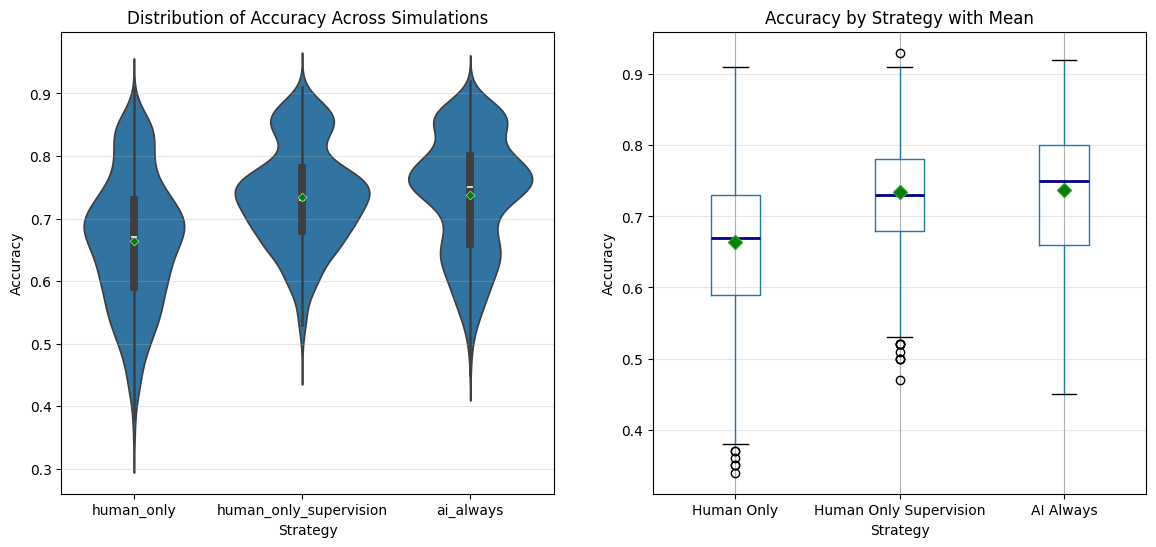

In [18]:
# Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Violin plot using seaborn
data_for_plot = pd.DataFrame(simulation_results['raw_results'])
#drop column ai_only
data_for_plot = data_for_plot.drop(columns=['ai_only'])
ax = axes[0]
# Melt the dataframe for seaborn
melted_data = data_for_plot.melt(var_name='Strategy', value_name='Accuracy')
sns.violinplot(
    data=melted_data,
    x="Strategy",
    y="Accuracy",
    order=["human_only", "human_only_supervision", "ai_always"],  # new order
    ax=axes[0]
)
means = (
    melted_data.groupby("Strategy", as_index=False)["Accuracy"].mean()
)
sns.scatterplot(
    data=means,
    x="Strategy",
    y="Accuracy",
    marker="D",
    s=20,
    color="green",
    zorder=10,
    ax=axes[0]
)
axes[0].set_title("Distribution of Accuracy Across Simulations")
axes[0].set_ylabel("Accuracy")
axes[0].grid(axis="y", alpha=0.3)

# Disagreement analysis
ax = axes[1]
details.boxplot(
    column=[
        "accuracy_human_only",
        "accuracy_human_only_supervision",
        "accuracy_ai_always"
    ],
    ax=ax,
    showmeans=True,
    meanprops={"marker": "D", "markerfacecolor": "green", "markersize": 7},
    medianprops={"color": "darkblue", "linewidth": 2},
)
ax.set_title("Accuracy by Strategy with Mean")
ax.set_xlabel("Strategy")
ax.set_ylabel("Accuracy")
ax.set_xticklabels(["Human Only", "Human Only Supervision", "AI Always"])
ax.grid(axis="y", alpha=0.3)

Simulation for each Video

In [19]:
video_simulation_results = helper.run_simulation_per_video(
    master_df=master_df,
    reference_df=reference,
    ai_site_key=f"{best_ai}_majority",
    human_site_keys=["clinic_3", "clinic_1", "clinic_2"],
    psy_cols=psy_cols_reduced,
    vid_col="video_id",
    ref_vid_col="ID_Video",
    site_col="site",
    id_col="id_code_v2",
    exclude_value=10000,
    haupttätigkeit_col="haupttätigkeit_v2",
    psychiatrist_codes=[2, 3, 5],
    videos_to_analyze=video_ids_in_ki_master
)
print("\n" + "="*80)
print("PER-VIDEO COMPARISON STATISTICS")
print("="*80)

for vid, sim_result in video_simulation_results.items():
    print(f"\nVIDEO {vid}:")
    helper.print_comparison_results(sim_result['comparisons'])


Processing Video 7...

Processing Video 8...

Processing Video 9...

PER-VIDEO COMPARISON STATISTICS

VIDEO 7:

PAIRWISE COMPARISON RESULTS WITH EFFECT SIZES

AI ALWAYS VS HUMAN ONLY
------------------------------------------------------------
Sample size: 990 paired observations

Mean ai_always: 0.7616
Mean human_only: 0.6671
Mean difference: 0.0945

ai_always better: 967/990
human_only better: 12/990
Ties: 11/990

Statistical Tests:
  Paired t-test:  t = 50.998, p = 4.118e-279 ***
  Wilcoxon test:  W = 398.0, p = 2.602e-161 ***

Effect Sizes:
  Cohen's d:        +1.621 (large)
    Interpretation: Small=0.2, Medium=0.5, Large=0.8
  r effect size:    +0.851 (large)
    Interpretation: Small=0.1, Medium=0.3, Large=0.5
  CLES (P(G1>G2)):  0.977
    Interpretation: Probability that ai_always > human_only
  Cliff's Delta:    +0.965 (large)
    Interpretation: Small=0.147, Medium=0.33, Large=0.474

HUMAN ONLY SUPERVISION VS HUMAN ONLY
-------------------------------------------------------

In [20]:
rows = []
for vid, sim_result in video_simulation_results.items():
    for comp_name, comp_stats in sim_result["comparisons"].items():
        row = {
            "video": vid,
            "comparison": comp_name,
            **comp_stats
        }
        rows.append(row)

df_all = pd.DataFrame(rows)
cols = ["video", "comparison"] + [c for c in df_all.columns if c not in ["video", "comparison"]]
df_all = df_all[cols]
df_all.to_csv(f"{output_folder_tables}/simulation_comparisons_all_videos.csv", index=False)

/Users/lenze/code/HITKIP/LLMs_psychopatholgies/src/utils/helper.py:2779: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



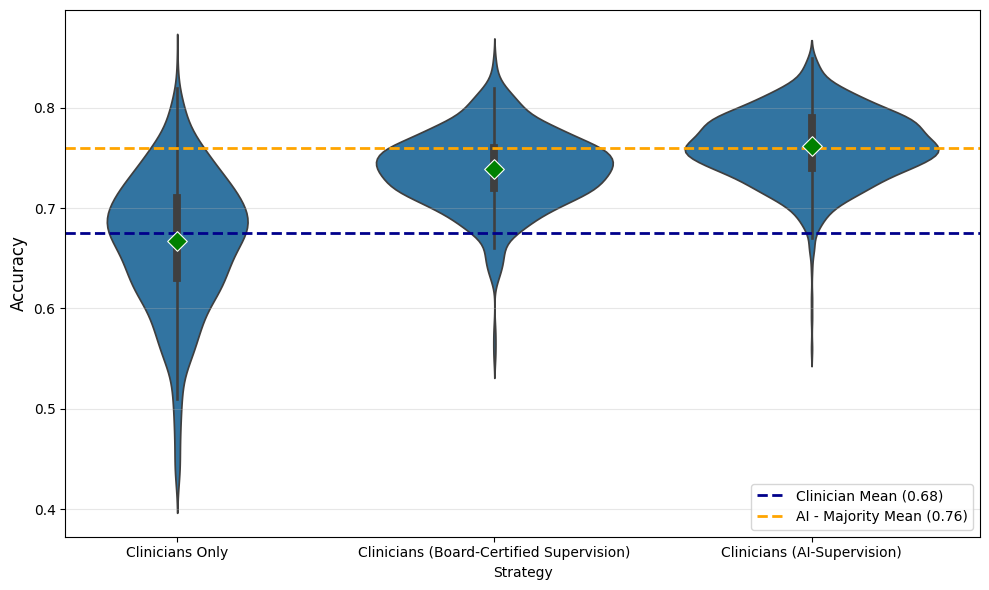


VIDEO 7 - MANIA STATISTICS
Human mean accuracy: 0.6751
AI majority accuracy: 0.7600

Simulation results:
  ai_always: 0.7616 ± 0.0347
  human_only: 0.6671 ± 0.0669
  human_only_supervision: 0.7386 ± 0.0381
  ai_only: 0.7600 ± 0.0000

Consultation statistics:
  Total pairs: 990
  Disagreement rate: 34.29%
  AI consultations: 33952
  Psychiatrist consultations: 33952


/Users/lenze/code/HITKIP/LLMs_psychopatholgies/src/utils/helper.py:2779: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



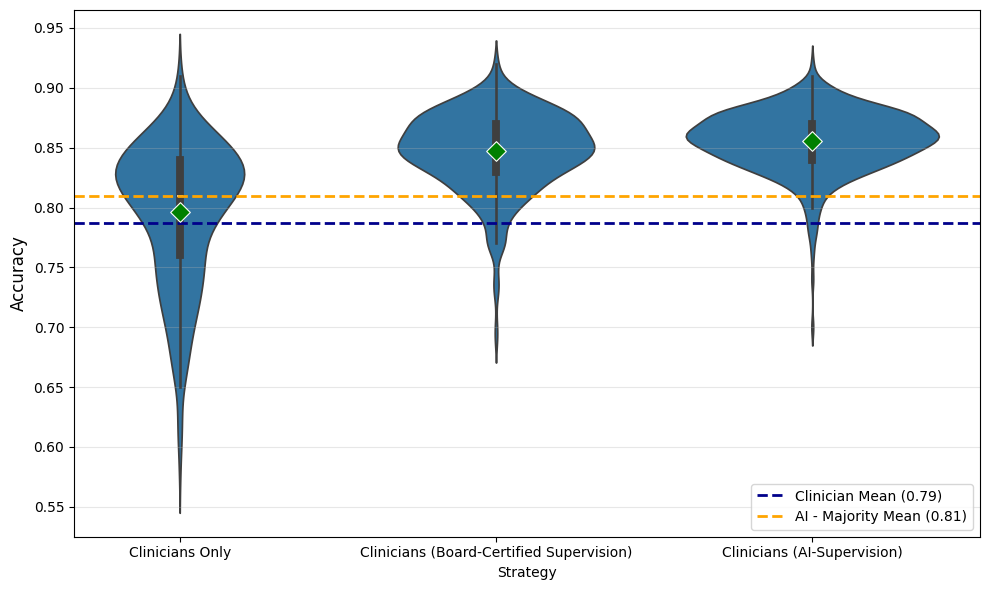


VIDEO 8 - DEPRESSION STATISTICS
Human mean accuracy: 0.7874
AI majority accuracy: 0.8100

Simulation results:
  ai_always: 0.8558 ± 0.0256
  human_only: 0.7962 ± 0.0589
  human_only_supervision: 0.8471 ± 0.0328
  ai_only: 0.8000 ± 0.0000

Consultation statistics:
  Total pairs: 435
  Disagreement rate: 24.15%
  AI consultations: 10507
  Psychiatrist consultations: 10507


/Users/lenze/code/HITKIP/LLMs_psychopatholgies/src/utils/helper.py:2779: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



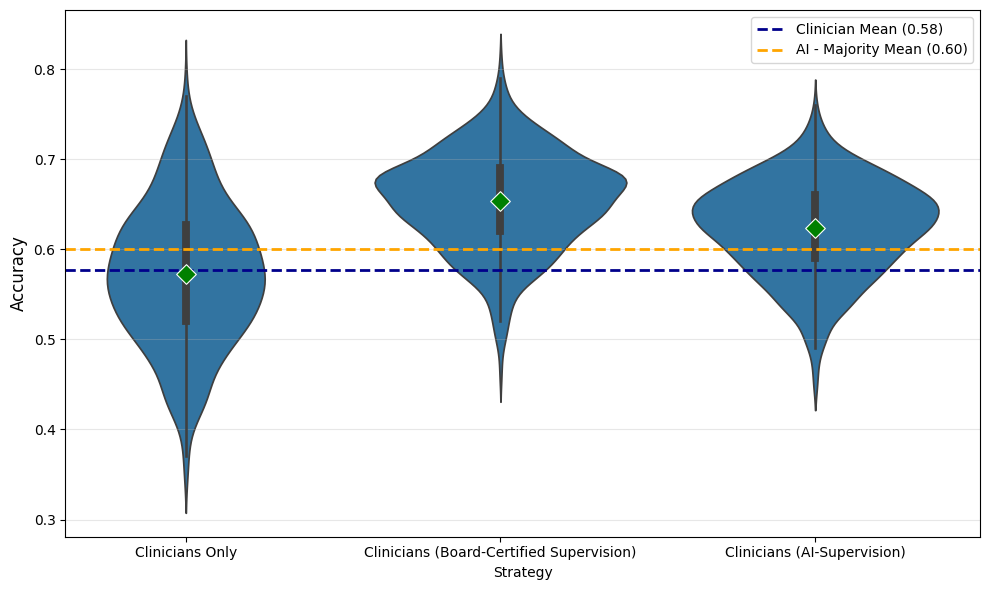


VIDEO 9 - SCHIZOPHRENIA STATISTICS
Human mean accuracy: 0.5773
AI majority accuracy: 0.6000

Simulation results:
  ai_always: 0.6240 ± 0.0522
  human_only: 0.5726 ± 0.0780
  human_only_supervision: 0.6539 ± 0.0535
  ai_only: 0.6000 ± 0.0000

Consultation statistics:
  Total pairs: 666
  Disagreement rate: 44.56%
  AI consultations: 29680
  Psychiatrist consultations: 29680


In [21]:
helper.plot_per_video_comparison(
    video_results=video_simulation_results,
    human_per_video=per_video_df_reduced[per_video_df_reduced['group'] == 'human'],
    ai_per_video=per_video_df_reduced[per_video_df_reduced['rater_id'] == 'AI_majority'],
    video_names={7: 'Mania', 8: 'Depression', 9: 'Schizophrenia'}
)

In [22]:
human_accs = rater_df_reduced[rater_df_reduced["group"] == "human"]["accuracy"].dropna().values
ai_accuracy = rater_df_reduced[rater_df_reduced["group"] == "ai"]["accuracy"].dropna().values

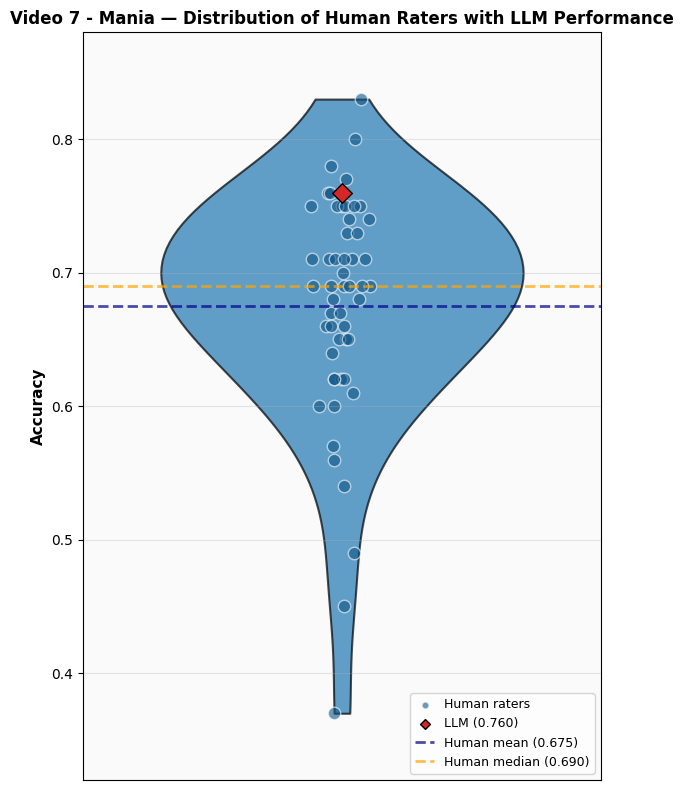

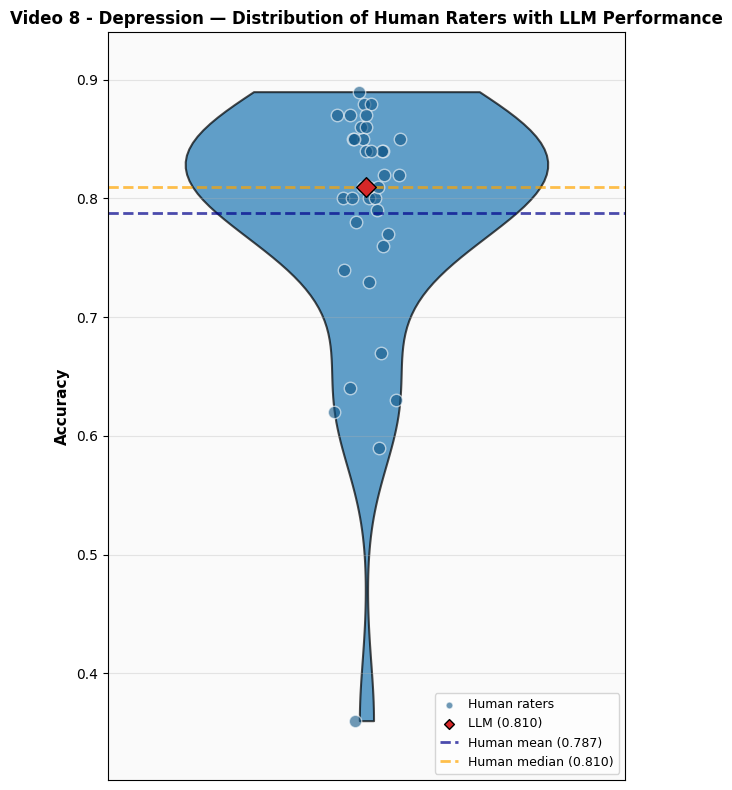

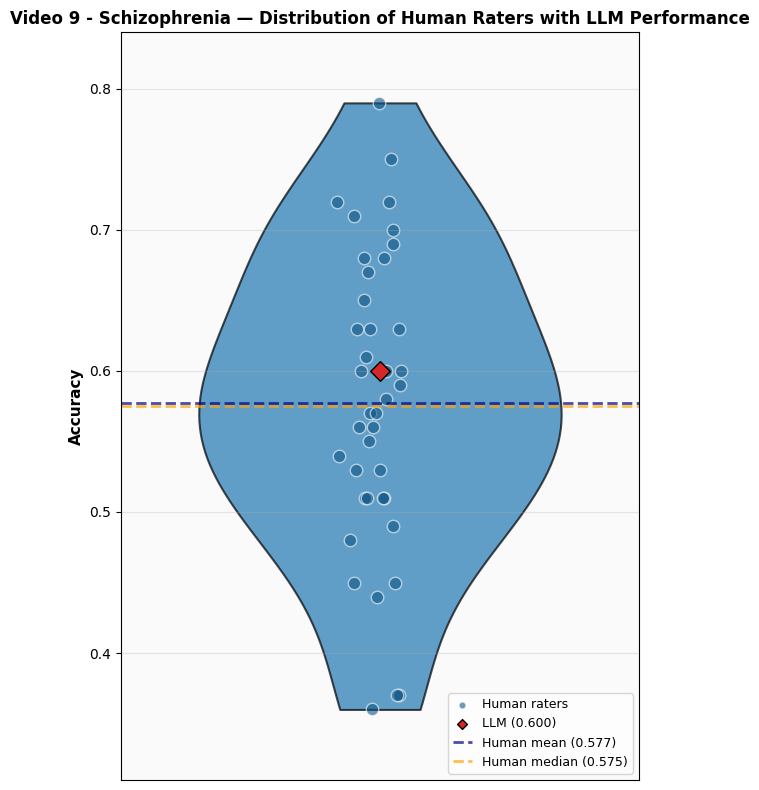

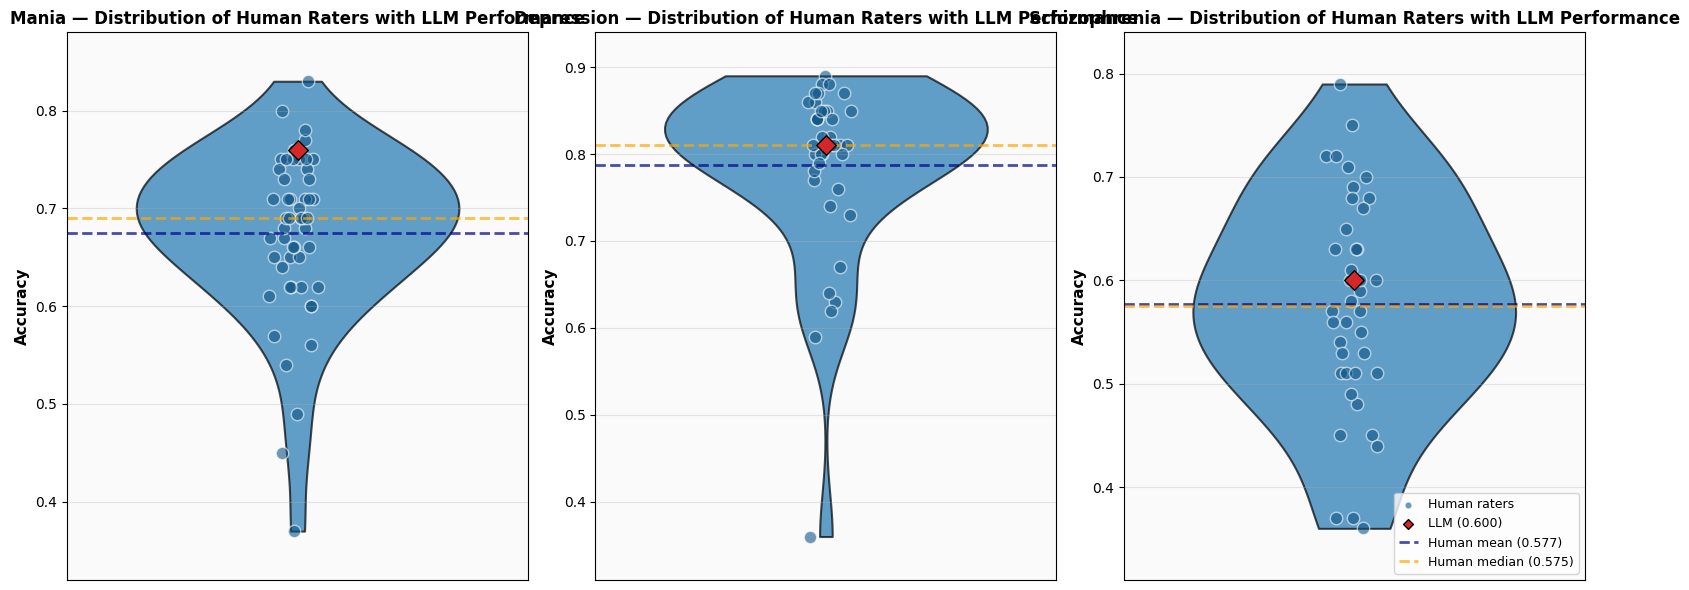

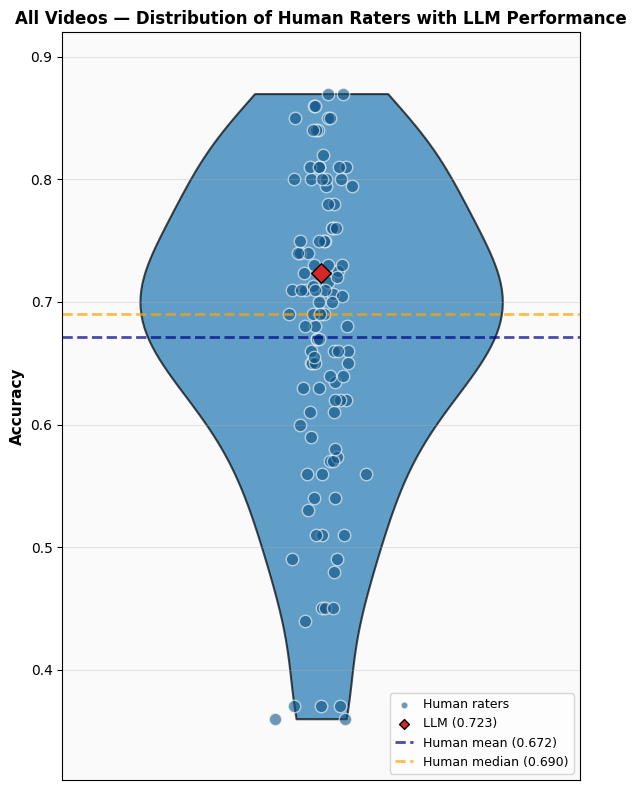

In [23]:
video_names = {7: 'Mania', 8: 'Depression', 9: 'Schizophrenia'}

for vid in video_ids_in_ki_master:
    # Get data for this video
    vid_data = per_video_df_reduced[per_video_df_reduced['video_id'] == vid]
    
    human_accs_vid = vid_data[
        (vid_data['group'] == 'human') &
        (vid_data['video_id'] == vid)
    ]['accuracy'].values
    
    ai_acc_vid = vid_data[
        (vid_data['rater_id'] == 'AI_majority') &
        (vid_data['video_id'] == vid)
    ]['accuracy'].values
    
    if len(human_accs_vid) > 0 and len(ai_acc_vid) > 0:
        fig, ax = helper.plot_human_vs_ai_violin(
            human_accs=human_accs_vid,
            ai_accuracy=float(ai_acc_vid[0]),
            video_id=f"Video {vid} - {video_names[vid]}",
            figsize=(6, 8),
            return_fig=True
        )
        plt.tight_layout()
        plt.show()


# Example 2: Create subplots for all videos at once
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

for idx, vid in enumerate([7, 8, 9]):
    vid_data = per_video_df_reduced[per_video_df_reduced['video_id'] == vid]
    
    human_accs_vid = vid_data[
        (vid_data['group'] == 'human') &
        (vid_data['video_id'] == vid)
    ]['accuracy'].values
    
    ai_acc_vid = vid_data[
        (vid_data['rater_id'] == 'AI_majority') &
        (vid_data['video_id'] == vid)
    ]['accuracy'].values
    
    if len(human_accs_vid) > 0 and len(ai_acc_vid) > 0:
        helper.plot_human_vs_ai_violin(
            human_accs=human_accs_vid,
            ai_accuracy=float(ai_acc_vid[0]),
            video_id=f"{video_names[vid]}",
            figsize=None,  # Don't create new figure
            show_legend=(idx == 2),  # Only show legend on last plot
            ax=axes[idx],
            return_fig=False
        )

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6, 8))

human_accs_all = rater_df_reduced[
    rater_df_reduced['group'] == 'human'
]['accuracy'].values

ai_acc_all = rater_df_reduced[
    rater_df_reduced['rater_id'] == 'AI_majority'
]['accuracy'].values

helper.plot_human_vs_ai_violin(
    human_accs=human_accs_all,
    ai_accuracy=float(ai_acc_all[0]),
    video_id="All Videos",
    ax=ax
)
plt.tight_layout()
plt.show()

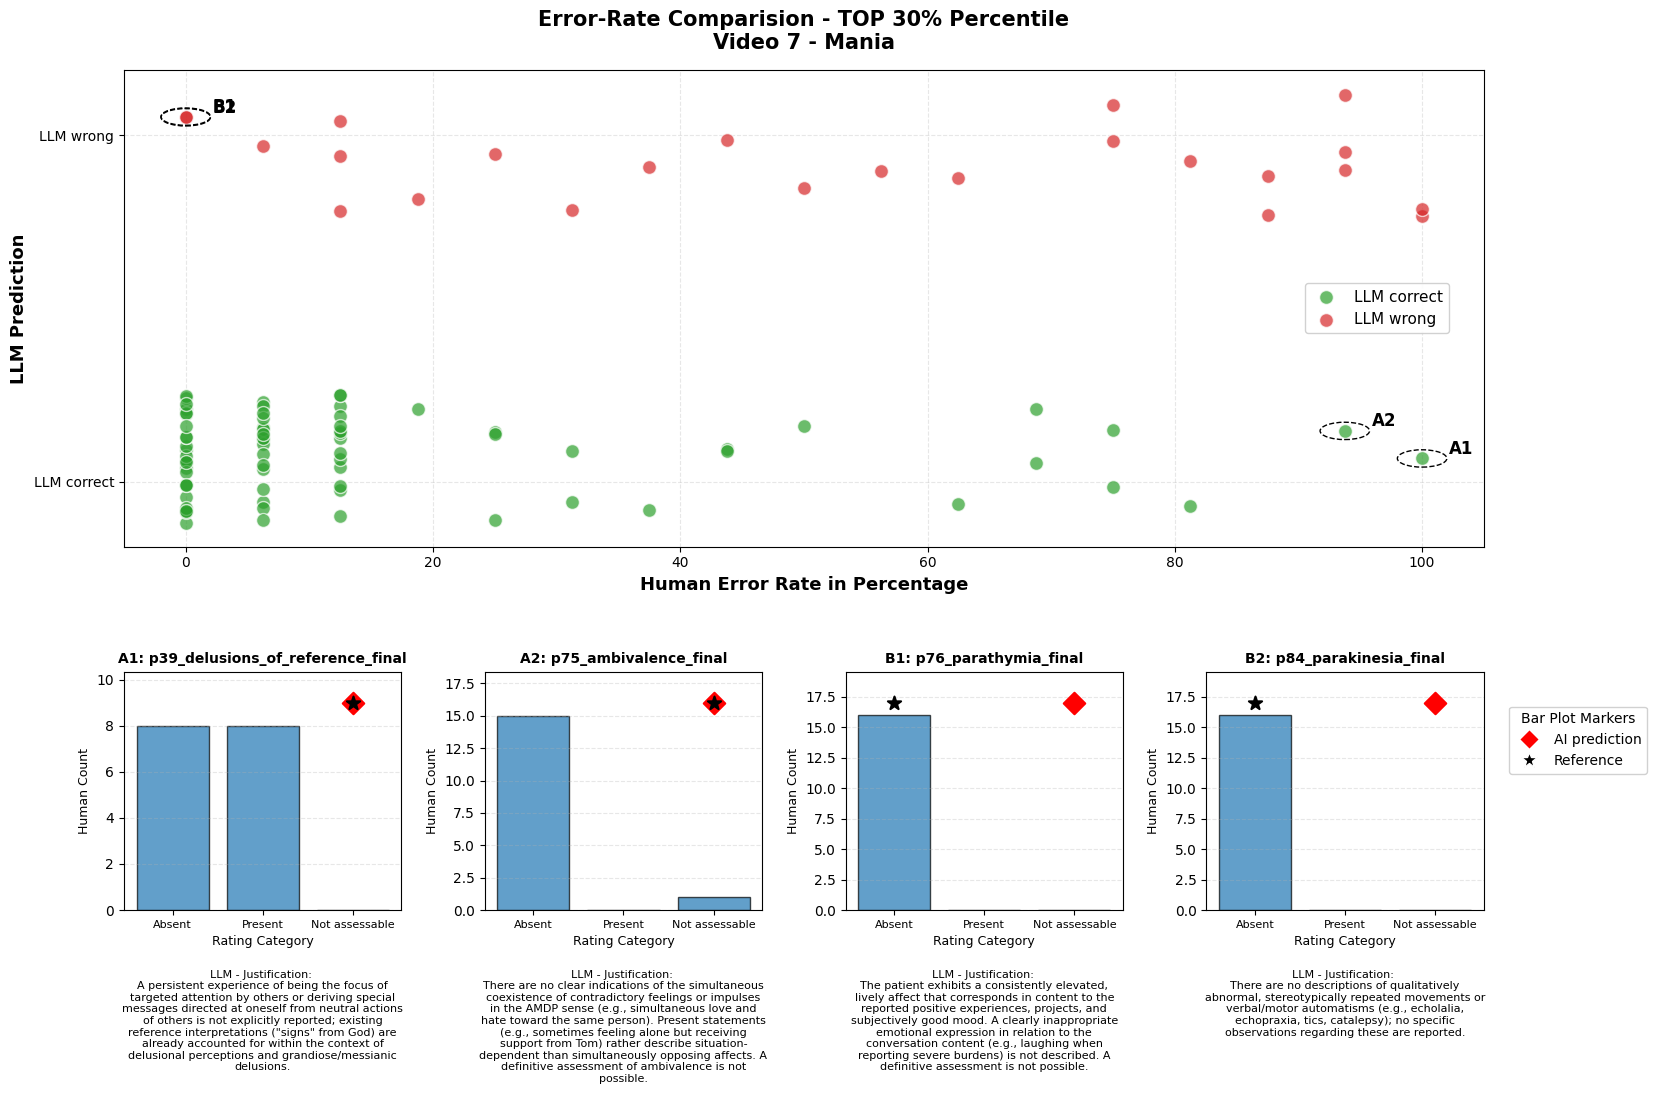


Video 7 - Mania
Total items: 100

Extreme Cases Selected:
  A1: p39_delusions_of_reference_final
      Human error: 100.0%, AI error: 0.0%
  A2: p75_ambivalence_final
      Human error: 93.8%, AI error: 0.0%
  B1: p76_parathymia_final
      Human error: 0.0%, AI error: 100.0%
  B2: p84_parakinesia_final
      Human error: 0.0%, AI error: 100.0%


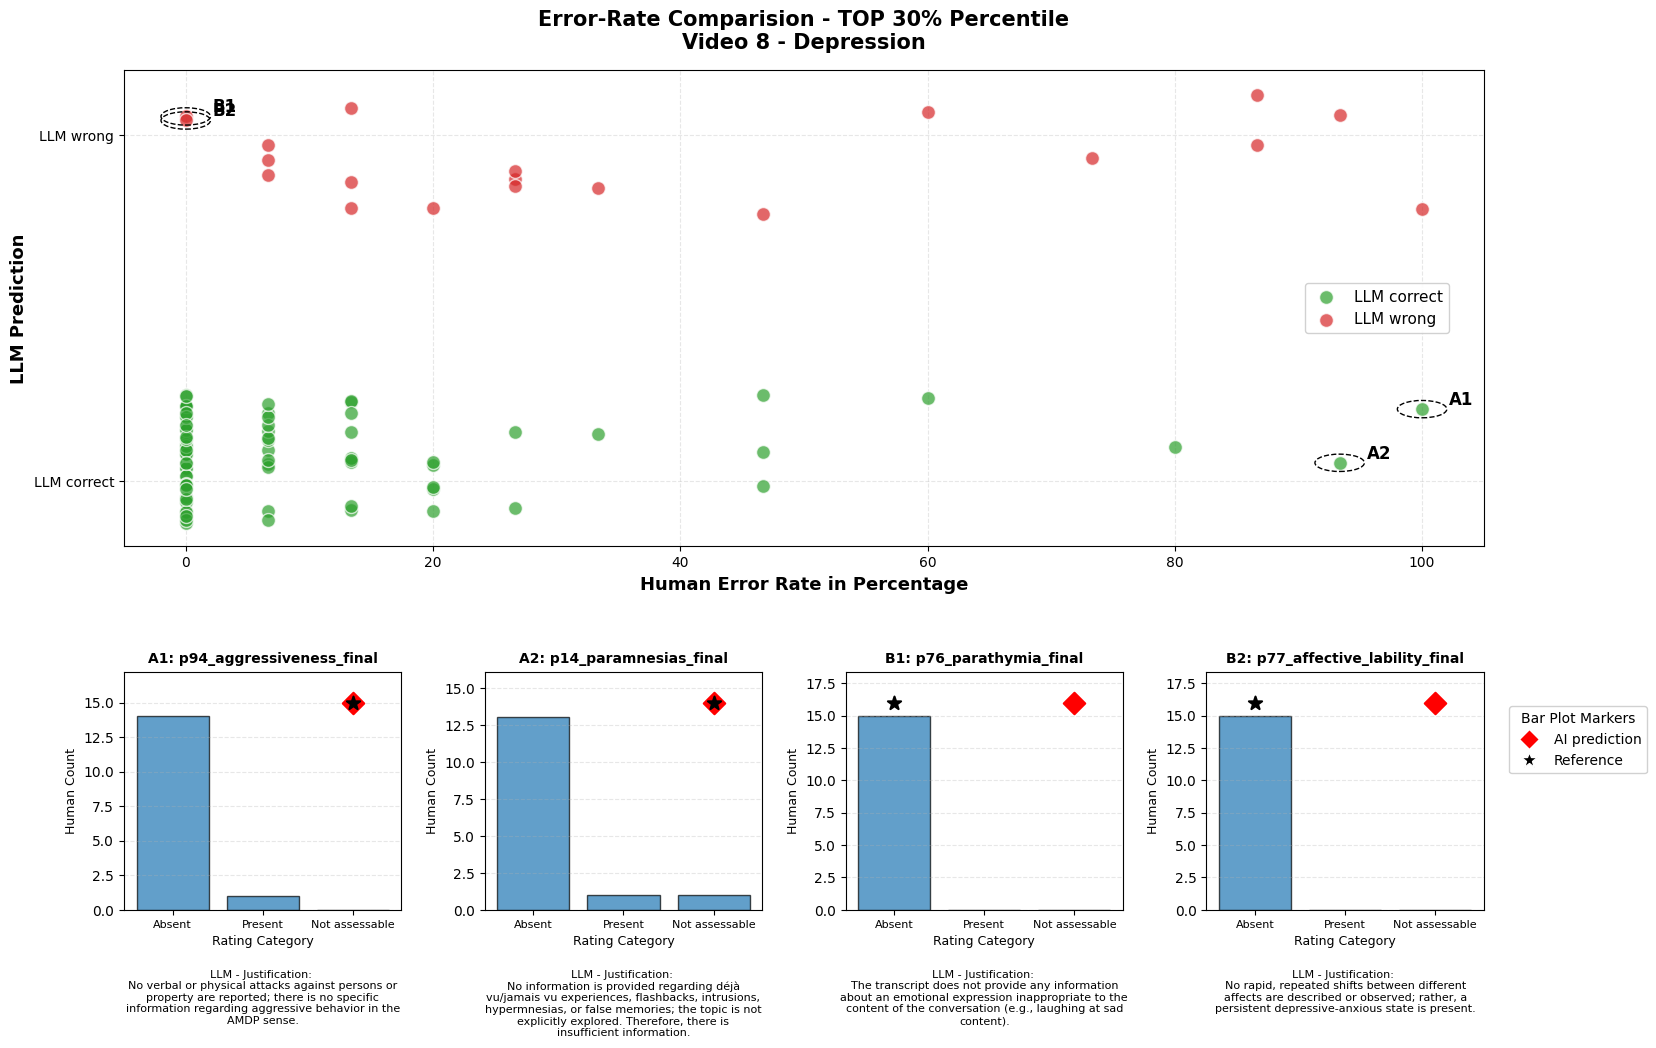


Video 8 - Depression
Total items: 100

Extreme Cases Selected:
  A1: p94_aggressiveness_final
      Human error: 100.0%, AI error: 0.0%
  A2: p14_paramnesias_final
      Human error: 93.3%, AI error: 0.0%
  B1: p76_parathymia_final
      Human error: 0.0%, AI error: 100.0%
  B2: p77_affective_lability_final
      Human error: 0.0%, AI error: 100.0%


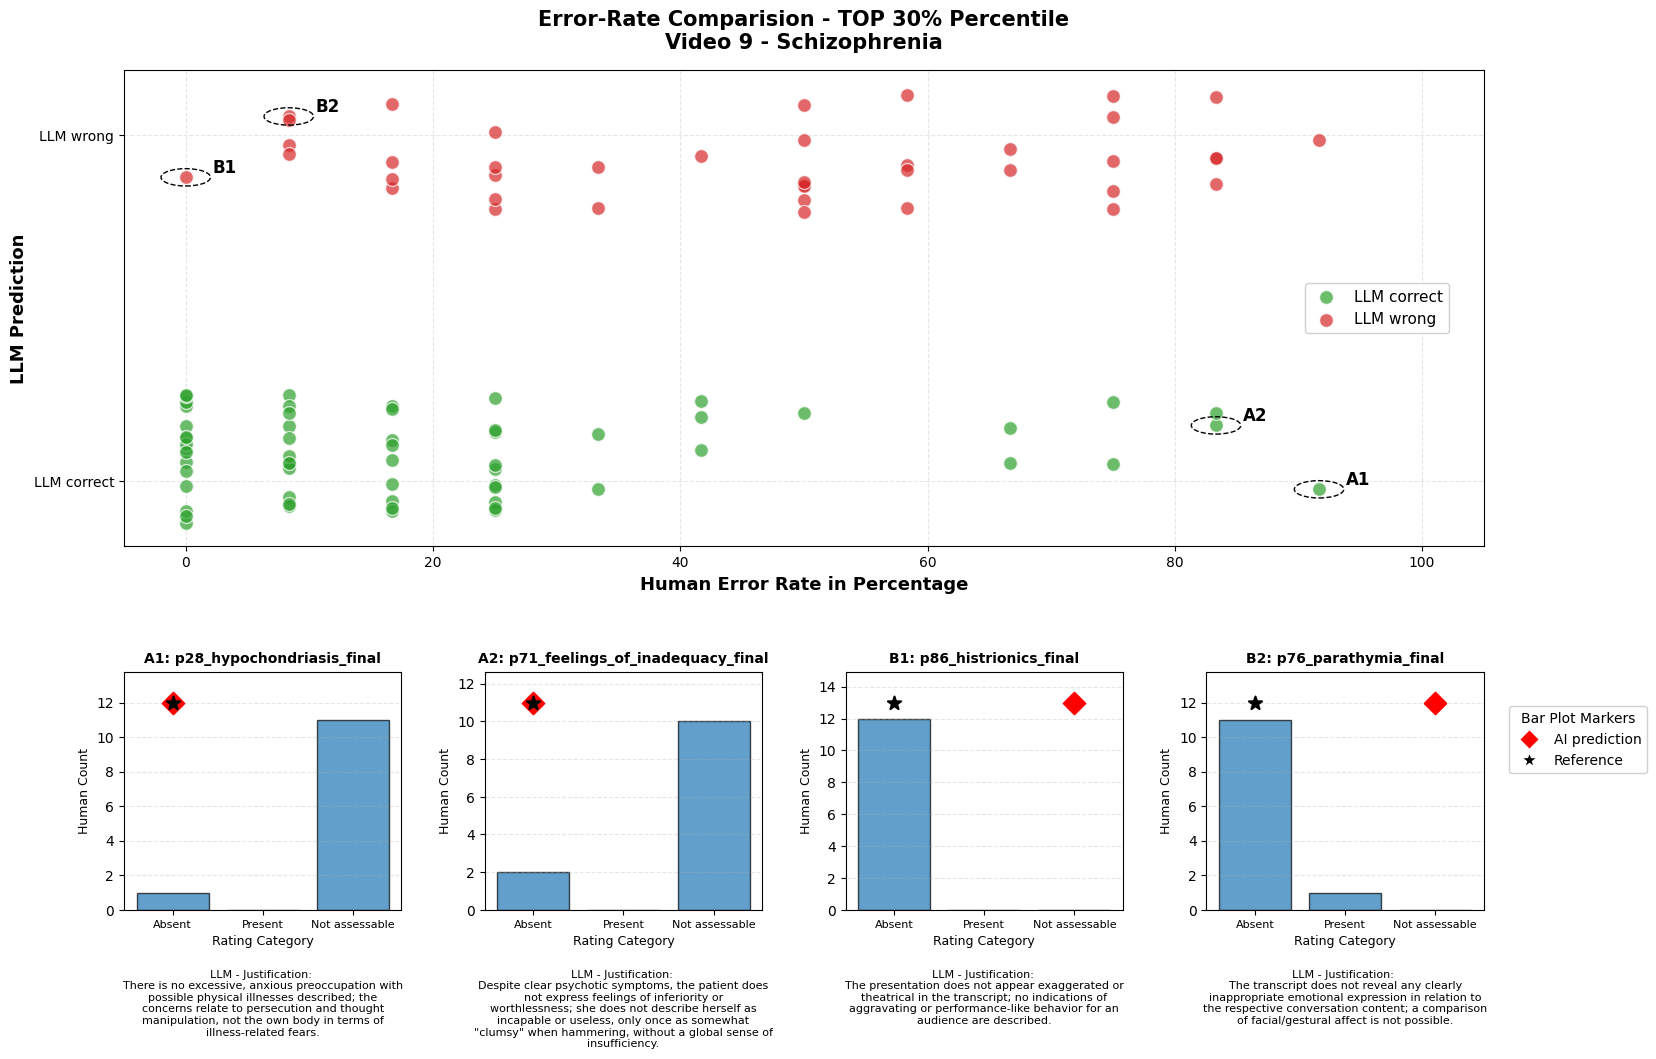


Video 9 - Schizophrenia
Total items: 100

Extreme Cases Selected:
  A1: p28_hypochondriasis_final
      Human error: 91.7%, AI error: 0.0%
  A2: p71_feelings_of_inadequacy_final
      Human error: 83.3%, AI error: 0.0%
  B1: p86_histrionics_final
      Human error: 0.0%, AI error: 100.0%
  B2: p76_parathymia_final
      Human error: 8.3%, AI error: 100.0%


[<Figure size 1700x1000 with 5 Axes>,
 <Figure size 1700x1000 with 5 Axes>,
 <Figure size 1700x1000 with 5 Axes>]

In [24]:
helper.create_publication_error_scatter_with_extreme_cases(
    master_df=high_performer_data.drop(columns=reduced_cols),
    reference=reference,
    best_ai=best_ai,
    psy_cols=psy_cols,
    video_ids=video_ids_in_ki_master,
    base_title="Error-Rate Comparision - TOP 30% Percentile")